### Forecast Performance Multiple Models

Having a baseline for forecast performance is essential, as it serves as a reference point for all other modeling techniques that we apply to solve the problem. If a model's performance is equal to or worse than the baseline, then that particular technique needs to be improved or discarded. The method used to generate the baseline forecast performance should be simple to implement and not take into account any specific details of the problem.

For time series datasets, the persistence algorithm is the most widely used baseline technique. Using the value at the current time step (t), it forecasts the expected result for the following time step (t+1). This algorithm satisfies the properties required for making a good baseline forecast, which are:

- Simplicity: Little to no intelligence or training is needed for this procedure.
- Speed: Making a prediction is computationally simple and can be implemented quickly.
- Determinism: Given the same input, this approach is deterministic, which means it yields the same output.

## CPU forecast with persistence algorithm

In [1]:
import pandas as pd
import os

# List of file paths
file_paths = ['rnd/2013-7/392.csv', 'rnd/2013-8/392.csv', 'rnd/2013-9/392.csv']

# Initialize an empty list to store each DataFrame
dataframes = []

# Loop through each file path, load the data, and append to the list
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';\t', engine='python')  # Load each file
    dataframes.append(df)  # Append the DataFrame to the list

# Concatenate all DataFrames in the list into a single DataFrame
data = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined dataframe to understand its structure
data.head()


,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1372629804,4,10640.109312,3771.918751,35.450000,16777072.0,4.932499e+06,655.266667,4429.933333,240.133333,699.600000
1,1372630104,4,10640.109312,2053.541097,19.300000,16777072.0,5.816100e+06,598.666667,2228.400000,238.066667,790.666667
2,1372630404,4,10640.109312,4027.281375,37.850000,16777072.0,6.476003e+06,57.000000,6571.333333,396.733333,511.133333
3,1372630704,4,10640.109312,1198.785649,11.266667,16777072.0,5.603589e+06,0.066667,253.200000,73.266667,491.000000
4,1372631004,4,10640.109312,1237.799383,11.633333,16777072.0,4.194302e+06,0.000000,98.333333,238.000000,483.666667


In [2]:
# Adjusting the timestamp to reflect the correct year and month ("2013-08")

# We will recalculate the timestamp considering that each measurement was taken every 5 minutes starting from August 2013
# Assuming the first record starts at the beginning of August 2013
start_date = "2013-07-01 00:00:00"
start_timestamp = pd.to_datetime(start_date)

# Generating timestamps for each row, assuming 5-minute intervals
timestamps = [start_timestamp + pd.Timedelta(minutes=5*i) for i in range(len(data))]

# Assigning the new timestamps to the dataframe
data['ds'] = timestamps

# Creating the two univariate datasets with the corrected timestamp
cpu_usage_dataset_with_corrected_timestamp = data[['ds', 'CPU usage [%]']].copy()
cpu_usage_dataset_with_corrected_timestamp  = cpu_usage_dataset_with_corrected_timestamp.rename(columns={'CPU usage [%]': 'y'})
cpu_usage_dataset_with_corrected_timestamp['unique_id'] = 'CPU_VM392'
memory_usage_dataset_with_corrected_timestamp = data[['ds', 'Memory usage [KB]']].copy()
memory_usage_dataset_with_corrected_timestamp = memory_usage_dataset_with_corrected_timestamp.rename(columns={'Memory usage [KB]': 'y'})
memory_usage_dataset_with_corrected_timestamp['unique_id'] = 'Memory_VM392'

# this makes it so that the outputs of the predict methods have the id as a column 
# instead of as the index
os.environ['NIXTLA_ID_AS_COL'] = '1'


# Displaying the first few rows of each corrected dataset to verify
cpu_usage_dataset_with_corrected_timestamp.head(), memory_usage_dataset_with_corrected_timestamp.head()




(                   ds          y  unique_id
 0 2013-07-01 00:00:00  35.450000  CPU_VM392
 1 2013-07-01 00:05:00  19.300000  CPU_VM392
 2 2013-07-01 00:10:00  37.850000  CPU_VM392
 3 2013-07-01 00:15:00  11.266667  CPU_VM392
 4 2013-07-01 00:20:00  11.633333  CPU_VM392,
                    ds             y     unique_id
 0 2013-07-01 00:00:00  4.932499e+06  Memory_VM392
 1 2013-07-01 00:05:00  5.816100e+06  Memory_VM392
 2 2013-07-01 00:10:00  6.476003e+06  Memory_VM392
 3 2013-07-01 00:15:00  5.603589e+06  Memory_VM392
 4 2013-07-01 00:20:00  4.194302e+06  Memory_VM392)

## Plot CPU 

/home/simone/.local/lib/python3.8/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


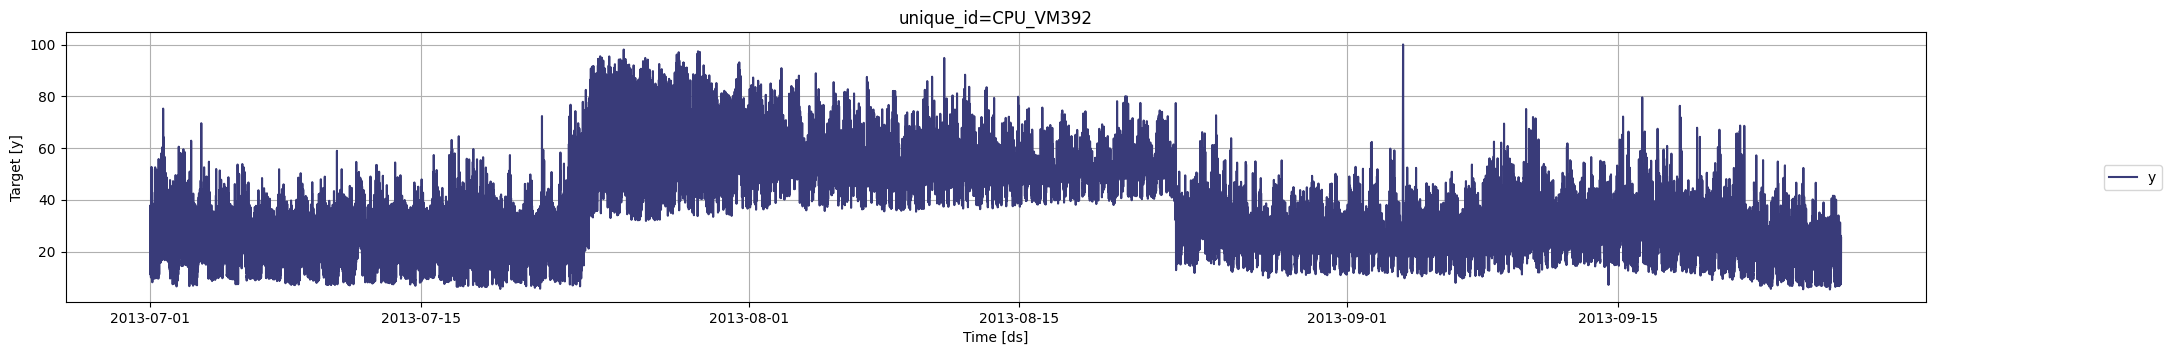

In [3]:
from statsforecast import StatsForecast
StatsForecast.plot(cpu_usage_dataset_with_corrected_timestamp)

## Plot Memory

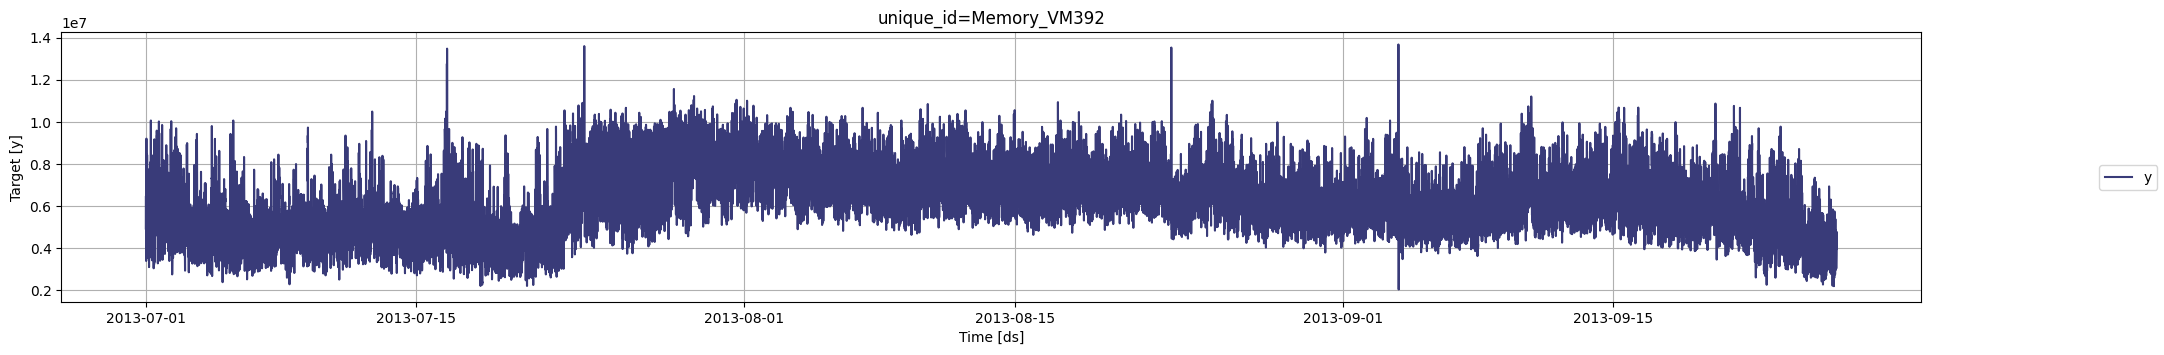

In [4]:
from statsforecast import StatsForecast
StatsForecast.plot(memory_usage_dataset_with_corrected_timestamp)

## Create CPU lagged Dataset

In [5]:
from statsforecast.models import (
    AutoARIMA,
    AutoETS, 
    #AutoCES,
    AutoTheta,
    HistoricAverage,
    SimpleExponentialSmoothingOptimized,
    Naive
)

# Create a list of models and instantiation parameters
models = [
    #AutoARIMA(season_length=1),
    #AutoETS(season_length=1),
    #AutoCES(),
    AutoTheta(season_length=2016),
    SimpleExponentialSmoothingOptimized(),
    #HistoricAverage(),
    #Naive()
]

# Instantiate StatsForecast class as sf
sf = StatsForecast( 
    models=models,
    freq='5min', 
    #fallback_model = Naive(),
    n_jobs=-1,
)

forecasts_df = sf.forecast(df=cpu_usage_dataset_with_corrected_timestamp, h=4032, level=[90])
forecasts_df.head()
forecasts_df.tail()



AttributeError: 'int' object has no attribute 'h'

In [ ]:
cpu_usage_dataset_with_corrected_timestamp

In [ ]:
forecasts_df

In [ ]:


sf.plot(cpu_usage_dataset_with_corrected_timestamp, forecasts_df, max_insample_length=30)

In [ ]:
sf.plot(cpu_usage_dataset_with_corrected_timestamp,forecasts_df)


In [ ]:
# Plot to unique_ids and some selected models
sf.plot(cpu_usage_dataset_with_corrected_timestamp, forecasts_df, models=["AutoARIMA","Naive"], unique_ids=["CPU_VM392"])


## Memory forecast with persistence algorithm

In [ ]:
sf.plot(cpu_usage_dataset_with_corrected_timestamp, forecasts_df, models=["AutoTheta"])

In [ ]:
crossvaldation_df = sf.cross_validation(
    df=cpu_usage_dataset_with_corrected_timestamp,
    h=4032,
    step_size=1008,
    n_windows=3
)


crossvaldation_df.head()
print(crossvaldation_df.info)

In [ ]:
from utilsforecast.losses import mse
from utilsforecast.evaluation import evaluate

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id','ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals
print(crossvaldation_df.columns)

evaluation_df = evaluate_cross_validation(crossvaldation_df, mse)
evaluation_df.head()

In [ ]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    df = forecasts_df.set_index(['unique_id', 'ds']).stack().to_frame().reset_index(level=2) # Wide to long 
    df.columns = ['model', 'best_model_forecast'] 
    df = df.join(evaluation_df[['best_model']])
    df = df.query('model.str.replace("-lo-90|-hi-90", "", regex=True) == best_model').copy()
    df.loc[:, 'model'] = [model.replace(bm, 'best_model') for model, bm in zip(df['model'], df['best_model'])]
    df = df.drop(columns='best_model').set_index('model', append=True).unstack()
    df.columns = df.columns.droplevel()
    df.columns.name = None
    df = df.reset_index()
    return df

prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df.head()

In [ ]:
sf.plot(cpu_usage_dataset_with_corrected_timestamp, prod_forecasts_df)
